In [34]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def image_rotate_crop(src, cnt, size):
    if len(src.shape) != 2:
        raise ValueError(
            "image_rotate_crop(): Source image should be in grayscale,",
            "and have two dimensions.",
        )
    image_width, image_height = src.shape  # cv2 takes rows and cols swapped
    M = cv2.moments(cnt)

    cx = int(M["m10"] / M["m00"])  # Calculate x,y coordinate of center
    cy = int(M["m01"] / M["m00"])

    # Get box around the contour
    (_, (rect_width, rect_height), angle) = cv2.minAreaRect(cnt)
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1)
    img_rot = cv2.warpAffine(
        src, M, (image_width, image_height), flags=cv2.INTER_LINEAR
    )

    # Calculate the top-left and bottom-right coordinates
    half_size = size // 2
    x1, y1 = max(0, cx - half_size), max(0, cy - half_size)
    x2, y2 = min(image_width, cx + half_size), min(image_height, cy + half_size)
    result = img_rot[y1:y2, x1:x2]

    # Make long side up
    if rect_height < rect_width:
        return cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)
    else:
        return result


def check_border_pixels(src):
    rows, cols = src.shape
    border_coordinates = []

    top_row = [(0, col) for col in range(cols)]
    bottom_row = [(rows - 1, col) for col in range(cols)]
    # Left and right columns exclude corners
    left_col = [(row, 0) for row in range(1, rows - 1)]
    right_col = [(row, cols - 1) for row in range(1, rows - 1)]

    border_coordinates.extend(top_row)
    border_coordinates.extend(bottom_row)
    border_coordinates.extend(left_col)
    border_coordinates.extend(right_col)

    threshold = 150
    saturated_pixels_count = 0

    for pixel in border_coordinates:
        if src[pixel[0]][pixel[1]] < threshold:
            saturated_pixels_count += 1

    if saturated_pixels_count >= 5:
        return True
    else:
        return False

dtype: uint8, shape: (122, 120, 3), min: 0, max: 255


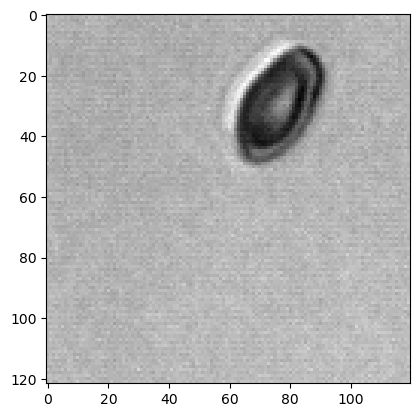

In [36]:
path = (
    "/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/large_cell.tif"
)
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"

print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, "gray")

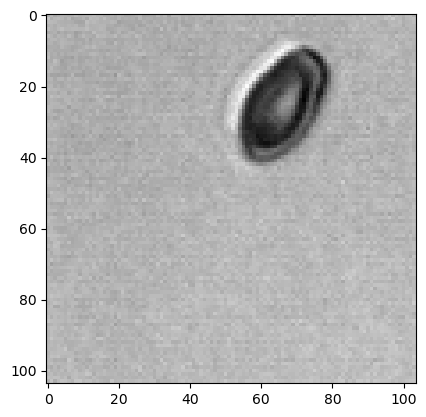

In [37]:
# Resize to 104x104
resized = cv2.resize(img, (104, 104), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized, "gray")

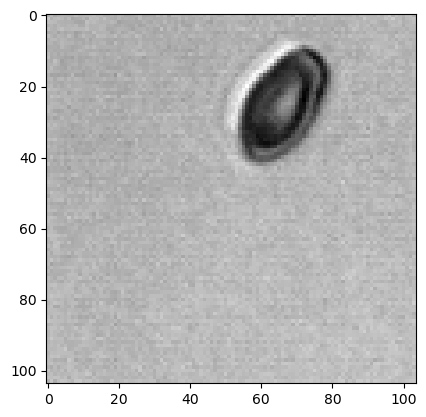

In [38]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="grey")

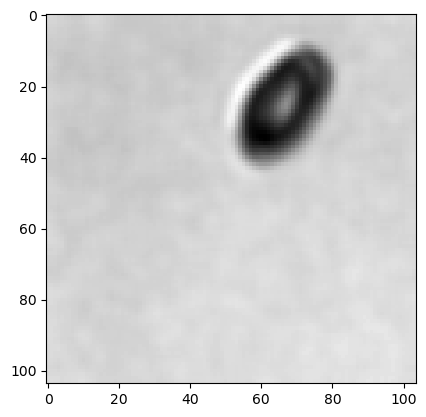

In [39]:
# Smooth image
blur = cv2.GaussianBlur(gray, (5, 5), 3)
plt.imshow(blur, cmap="grey")

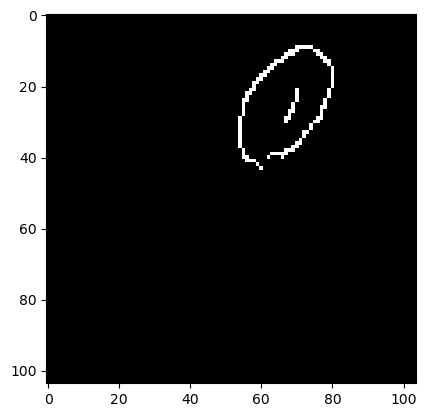

In [40]:
# Detect edges
edges = cv2.Canny(blur, threshold1=150, threshold2=200)
plt.imshow(edges, cmap="gray")

In [41]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

valid_contours = []

for contour, h in zip(contours, hierarchy[0]):
    # Check if the contour is not inside another (parent index is -1)
    if h[3] == -1:
        area = cv2.contourArea(contour)
        if 200 <= area <= 600:
            valid_contours.append(contour)

if len(valid_contours) != 1:
    print("Image contains duplicte cells, excluding!")

Image contains duplicte cells, excluding!


In [42]:
# Croppingout 64x64
new_image_size = 64
rotated_cropped = image_rotate_crop(gray, valid_contours[0], new_image_size)

plt.imshow(rotated_cropped, cmap="grey")

IndexError: list index out of range

In [ ]:
import hashlib

bytes = gray.tobytes()
salt = os.urandom(16)  # 16 bytes of randomness
bytes_with_salt = bytes + salt  # append the salt to the file content
readable_hash = hashlib.sha256(bytes_with_salt).hexdigest()

In [ ]:
hash = readable_hash[:32]

In [ ]:
cv2.imwrite(f"{hash}.jpeg", gray)

True